In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit
%run helpers.ipynb
%run classifiers.ipynb

In [93]:
n_bins=3 # Number of classes for the labels

In [94]:
amt_data = pd.read_csv('big_amt_updated.csv')
len(amt_data)

C:\Users\Samarth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


167118

In [95]:
# Remove rows with -ve work_time
#amt_data = amt_data[amt_data['work_time']>0]
amt_data = remove_negatives_from_column(data=amt_data,column_name='work_time')
# Remove rows with turkopticon values Nan
#amt_data = amt_data[amt_data['turkopticon_comm'].notnull()]
amt_data = remove_null_from_column(data=amt_data, column_name='turkopticon_comm')

amt_data = add_pay_per_hr_column(data=amt_data, column_name='pay_per_hr')
len(amt_data)

165572

In [96]:
num_columns = len(amt_data.columns)
col_to_keep = [8] + list(range(11,num_columns))
amt_reduced = amt_data.iloc[:,col_to_keep]
amt_reduced.columns

Index(['work_time', 'worker_qualifications', 'group_hourly_rate',
       'dropped_hits', 'finished_hits', 'turkopticon_comm', 'turkopticon_fair',
       'turkopticon_fast', 'turkopticon_pay', 'requester_rejected_hits',
       'requester_approved_hits', 'pay_per_hr'],
      dtype='object')

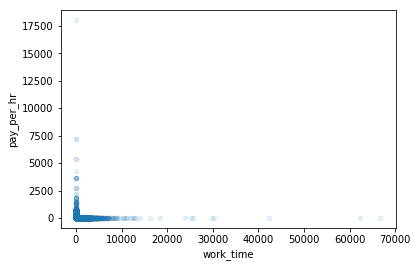

In [97]:
# Plot work_time vs pay_per_hr
amt_reduced.plot(kind="scatter", x="work_time", y="pay_per_hr", alpha=0.1)

In [98]:
# From the above plot, it looks like there are very few values beyond work_time=10000. The code below removes the work_time outliers
amt_reduced = filter_data_by_column(data=amt_reduced, column_name='work_time', value=600, logic='less_than')

Entries: 158728


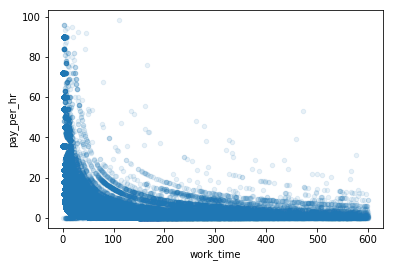

In [99]:
# Removing all entries with pay_per_hr>100 (Outliers) (100$ per hr is itself very high)
amt_reduced = filter_data_by_column(data=amt_reduced, column_name='pay_per_hr', value=100, logic='less_than')
print("Entries: {0}".format(len(amt_reduced)))
amt_reduced.plot(kind="scatter", x="work_time", y="pay_per_hr", alpha=0.1) # Scatter plot of work_time vs pay_per_hr

In [100]:
# Since the work_time values range from 1 to ~65000, it is hard to classify with their original values.
# Hence, we will be taking log of the work_time values
amt_data_log = log_of_column(data=amt_reduced, column_name='work_time')
# divide pay_per_hr into bins
# if n_bins=2, we split at 4
# if n_bins=3, we split at 4 and 8
# if n_bins=5, we split at 2,4,6,8
amt_data_log['pay_per_hr'] = create_bins(n_bins,amt_data_log['pay_per_hr'].copy())
amt_data_log.head()

,work_time,worker_qualifications,group_hourly_rate,dropped_hits,finished_hits,turkopticon_comm,turkopticon_fair,turkopticon_fast,turkopticon_pay,requester_rejected_hits,requester_approved_hits,pay_per_hr
0,2.705008,0,1545.06,250,335,3.64,4.47,4.23,3.36,4004,4,1.0
2,0.301030,468,36.92,226,824,5.00,5.00,5.00,4.95,1,2,2.0
3,2.232996,468,12.62,226,824,3.50,5.00,4.93,3.54,471,0,2.0
4,2.638489,468,28.97,226,824,5.00,5.00,5.00,4.40,4,0,2.0
5,1.799341,468,17.37,226,824,5.00,4.93,4.25,2.81,300,1,2.0


In [101]:
# Categorise work_time
"""
0-1 ----> Class 0
1-2 ----> Class 1
2-3 ----> Class 2
3-4 ----> Class 3
4-5 ----> Class 4
"""
amt_data_log = floor_column_values(data=amt_data_log, column_name='work_time')
print(amt_data_log['work_time'].value_counts())
print(amt_data_log['pay_per_hr'].value_counts())

1    82821
0    49191
2    26716
Name: work_time, dtype: int64
0.0    75371
2.0    44343
1.0    39014
Name: pay_per_hr, dtype: int64


In [102]:
# One hot encode the work_time column
amt_data_log_encoded = one_hot_encoding(data=amt_data_log, column_name='work_time')

In [103]:
# To keep equal percentage of pay_per_hr category in test and train sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(amt_data_log_encoded, amt_data_log_encoded['pay_per_hr']):
    strat_train_set = amt_data_log_encoded.loc[train_index]
    strat_test_set = amt_data_log_encoded.loc[test_index]

In [104]:
print(strat_test_set['pay_per_hr'].value_counts()/len(strat_test_set))
print(strat_train_set['pay_per_hr'].value_counts()/len(strat_train_set))

0.0    0.474831
2.0    0.279374
1.0    0.245795
Name: pay_per_hr, dtype: float64
0.0    0.474847
2.0    0.279362
1.0    0.245791
Name: pay_per_hr, dtype: float64


In [105]:
X_train, y_train, X_test, y_test = input_label_split(strat_train_set, strat_test_set)

In [106]:
print(X_train.shape)
print(X_test.shape)

(126982, 12)
(31746, 12)


In [107]:
# Feature normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
# Run Decision tree
run_decision_tree(X_train, y_train, X_test, y_test)

DT Test Score: 0.8063378063378064
DT Train Score: 0.820289489848955
Confusion Matrix: [[14186   738   150]
 [ 1383  4178  2242]
 [  206  1429  7234]]


In [109]:
# Random Forest classifier
train_score, test_score, rfc_y_pred, confusion_matrix, feature_importances, rfc = run_random_forest(X_train, y_train, X_test, y_test)

RF Test Score: 0.8075033075033075
RF Train Score: 0.8202816147170465
RF Confusion Matrix: [[14186   745   143]
 [ 1366  4200  2237]
 [  197  1423  7249]]
RF Feature Importance:                          importance
work_time_1                0.197473
group_hourly_rate          0.190586
work_time_2                0.125698
requester_rejected_hits    0.098710
requester_approved_hits    0.085432
dropped_hits               0.061449
turkopticon_pay            0.058315
turkopticon_comm           0.051378
finished_hits              0.046894
turkopticon_fast           0.039114
turkopticon_fair           0.037332
worker_qualifications      0.007619


In [71]:
y_test_array = np.array(y_test)

In [72]:
rfc_y_pred = rfc.predict_proba(X_test)
print(rfc_y_pred[:20,:])
print(y_test_array[:20])

[[0.8324109  0.1675891 ]
 [0.         1.        ]
 [0.01514632 0.98485368]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.63967528 0.36032472]
 [0.         1.        ]
 [0.84523139 0.15476861]
 [0.         1.        ]
 [0.58770753 0.41229247]
 [0.         1.        ]
 [0.68       0.32      ]
 [0.68034404 0.31965596]
 [1.         0.        ]
 [0.0688107  0.9311893 ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]


In [73]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

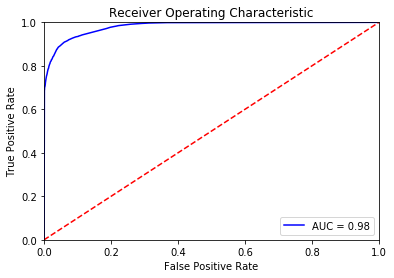

In [74]:
if n_bins == 2: plot_roc_2_class(y_test_array, rfc_y_pred[:,1])

In [268]:
"""Run the code below to plot roc of 3 classes (or more by tweaking some code)"""
y_test_lb = label_binarize(y_test_array, classes=[0, 1, 2])
rfc_one_vs_rest = OneVsRestClassifier(rfc)
rfc_one_vs_rest.fit(X_train, y_train)
rfc_ypred_ovr = rfc_one_vs_rest.predict_proba(X_test)
#rfc_ypred_ovr_lb = label_binarize(rfc_ypred_ovr, classes=[0, 1, 2])
print(rfc_ypred_ovr)

(31848,)
[[0.         0.47549409 0.52450591]
 [0.89960934 0.10039066 0.        ]
 [0.02941176 0.         0.97058824]
 ...
 [0.         0.32982973 0.67017027]
 [1.         0.         0.        ]
 [0.         0.75148804 0.24851196]]


In [269]:
print(y_test_lb.shape)
print(rfc_ypred_ovr.shape)

(31848, 3)
(31848, 3)


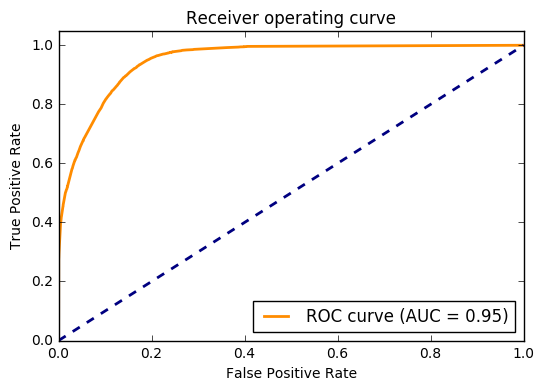

In [270]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_lb[:, i], rfc_ypred_ovr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_lb.ravel(), rfc_ypred_ovr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Run Neural network with one hidden layer
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initializing the ANN
nn_clf = Sequential()

# Adding first hidden layer
nn_clf.add(Dense(units=7, kernel_initializer = 'uniform', activation='relu', input_dim=14))

# Adding second hidden layer
#nn_clf.add(Dense(units=6, kernel_initializer ='uniform',activation='relu'))

# Adding third hidden layer
#n_clf.add(Dense(units=8, kernel_initializer= 'uniform', activation='relu'))

# Output layer
nn_clf.add(Dense(units=1,kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
nn_clf.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Fitting the ANN to the training set
nn_clf.fit(X_train, y_train, batch_size=100, epochs = 100)

# Score
nn_clf.evaluate(X_test, y_test)